#T-Shirt Detection Attempt

I train a custom object tetector with T-shirts for my final year project. Credits to [Tony607's object detection demo](https://github.com/Tony607/object_detection_demo) which formed the backbone of the implementation.

##Setting Up Chosen Model and Variables

In [0]:
#training steps
train_steps = 1000

#validation steps
test_steps = 50

#name of the object detection model to use
MODEL = 'ssd_mobilenet_v2_coco_2018_03_29'

#name of the pipeline file in tensorflow object detection API
model_config = 'ssd_mobilenet_v2_coco.config'

#how much the model will feed through the network every increment
batch_size = 12

## Clone My Repo to the Colab  Folder

We do this so that we can work with the files needed for training and testing.

In [0]:
import os

#my FYP repo
my_repo = 'https://github.com/frampos/object_detection_demo'

#'%' executes certain magic commands (ipython)
#change directory to content folder
#/content is the root folder of Google Colab and has to be appended to all paths used in the notebook
%cd /content

#refer to path of the cloned repo regardless of the location of the repo
cloned_dir = os.path.abspath(os.path.join('.', os.path.basename(my_repo)))

#take changes from remote repo into the current
!git clone {my_repo}
%cd {cloned_dir}
!git pull

print("Cell Done.")

/content
Cloning into 'object_detection_demo'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 358 (delta 2), reused 5 (delta 2), pack-reused 349
Receiving objects: 100% (358/358), 21.73 MiB | 3.97 MiB/s, done.
Resolving deltas: 100% (155/155), done.
/content/object_detection_demo
Already up to date.
Cell Done.


##TensorFlow Object Detection API and its dependencies

I follow the steps for installing the API [here](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md). The code below installs the API and its dependencies.

In [0]:
%cd /content

#clone the TensorFlow API itself
!git clone --quiet https://github.com/tensorflow/models.git

#"protobuf compiler" installation
!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk

#remaining libraries
!pip install -q Cython
!pip install -q contextlib2
!pip install -q jupyter
!pip install -q matplotlib
!pip install -q pillow
!pip install -q pycocotools
!pip install numpy==1.17.5

%cd /content/models/research

#execute protobuf compilation
#the compiler converts .proto files to .py files
!protoc object_detection/protos/*.proto --python_out=.

#add Libraries to PYTHONPATH
#maintain directories of custom Python libraries
import os
os.environ['PYTHONPATH'] += ':/content/models/research/:/content/models/research/slim/'

#verifying installation
!python object_detection/builders/model_builder_test.py

print("Cell Done.")

/content
Selecting previously unselected package python-bs4.
(Reading database ... 144542 files and directories currently installed.)
Preparing to unpack .../0-python-bs4_4.6.0-1_all.deb ...
Unpacking python-bs4 (4.6.0-1) ...
Selecting previously unselected package python-pkg-resources.
Preparing to unpack .../1-python-pkg-resources_39.0.1-2_all.deb ...
Unpacking python-pkg-resources (39.0.1-2) ...
Selecting previously unselected package python-chardet.
Preparing to unpack .../2-python-chardet_3.0.4-1_all.deb ...
Unpacking python-chardet (3.0.4-1) ...
Selecting previously unselected package python-six.
Preparing to unpack .../3-python-six_1.11.0-2_all.deb ...
Unpacking python-six (1.11.0-2) ...
Selecting previously unselected package python-webencodings.
Preparing to unpack .../4-python-webencodings_0.5-2_all.deb ...
Unpacking python-webencodings (0.5-2) ...
Selecting previously unselected package python-html5lib.
Preparing to unpack .../5-python-html5lib_0.999999999-1_all.deb ...
Unpa

/content/models/research
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Running tests under Python 3.6.9: /usr/bin/python3
[ RUN      ] ModelBuilderTest.test_create_experimental_model
[       OK ] ModelBuilderTest.test_create_experimental_model
[ RUN      ] ModelBuilderTest.test_create_faster_rcnn_model_from_config_with_example_miner
[       OK ] ModelBuilderTest.test_create_faster_rcnn_model_from_config_with_example_miner
[ RUN      ] ModelBuilderTest.test_create_faster_rcnn_models_from_config_faster_rcnn_with_matmul
[       OK ] ModelBuilderTest.test_create_faster_rcnn_models_from_config_faster_rcnn_with_matmul
[ RUN      ] ModelBuilderTest.test_create_faster_rcnn_models_f

##Generate TFRecords

API requires TFRecords for training and testing.


In [1]:
%cd {cloned_dir}

#pass arguments to xml_to_csv.py to convert the .xml annotations to one .csv file
!python xml_to_csv.py
!python generate_tfrecord.py --csv_input=data/annotations/train_labels.csv --output_path=data/annotations/train.record --img_path=data/images/train
!python generate_tfrecord.py --csv_input=data/annotations/test_labels.csv --output_path=data/annotations/test.record --img_path=data/images/test

#assign the records and label map to variables
train_record = '/content/object_detection_demo/data/annotations/train.record'
test_record = '/content/object_detection_demo/data/annotations/test.record'
label_map_pbtxt = '/content/object_detection_demo/data/annotations/label_map.pbtxt'

print("Cell Done.")

[Errno 2] No such file or directory: '{cloned_dir}'
/content
python3: can't open file 'xml_to_csv.py': [Errno 2] No such file or directory
python3: can't open file 'generate_tfrecord.py': [Errno 2] No such file or directory
python3: can't open file 'generate_tfrecord.py': [Errno 2] No such file or directory
Cell Done.


## Download Base Model

The base model comes from the [TensorFlow model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) and comes as a compressed .tar file.

*Disclaimer: This cell was not written by me but was used as part of the implementation. Code was taken from [here](https://gist.github.com/AlaaSenjab/ac61b3b23793f9e07c2aa6ca0cff3285).*


In [0]:
%cd /content/models/research

import os
import shutil
import glob
import urllib.request
import tarfile

#base model comes as a tar file, this concatenates the name defined earlier and appends the tar extension to the string
MODEL_FILE = MODEL + '.tar.gz'

#link to base model downloaded
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

#save destination
DEST_DIR = '/content/models/research/pretrained_model'

if not (os.path.exists(MODEL_FILE)):
    #model name is downloaded 
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

#must extract the tarfile
tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

#removes the unextracted tar file once the extraction is complete
os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
    shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

print("Cell Done.")

/content/models/research
Cell Done.


## Changing the Model Configuration

The model config file contains the information of the neural network layers and feature extraction behaviour. There a many configs already available within the TensorFlow object detection API so I decided to use one.


In [0]:
import os

#full path of the model configuration
config_path = os.path.join('/content/models/research/object_detection/samples/configs/', model_config)
assert os.path.isfile(config_path), '`{}` not exist'.format(config_path)

print("Cell Done.")

Cell Done.


*Disclaimer: The cell below was not written by me but was used as part of the implementation. Code was taken from [here](https://gist.github.com/Said-Akbar/2d749d497ec6c928037660b6cab3bcb3).*

In [0]:
#regrex library
import re

#set the checkpoint destination folder
fine_tune_checkpoint = os.path.join(DEST_DIR, "model.ckpt")

# the label map generated earlier would count only 1 class as there was only one class label in the .xml, "T-shirt"
num_classes = 1

#read in the .config file
with open(config_path) as f:
    s = f.read()
with open(config_path, 'w') as f:
    
    # fine_tune_checkpoint
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)
    
    # tfrecord files train and test
    s = re.sub(
        '(input_path: ".*?)(train.record)(.*?")', 'input_path: "{}"'.format(train_record), s)
    s = re.sub(
        '(input_path: ".*?)(val.record)(.*?")', 'input_path: "{}"'.format(test_record), s)

    # label_map_path
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_pbtxt), s)

    # Set training batch_size.
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    # Set training steps, train_steps
    s = re.sub('train_steps: [0-9]+',
               'train_steps: {}'.format(train_steps), s)
    
    # Set number of classes num_classes
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)
    f.write(s)

print("Cell Done.")

Cell Done.


In [0]:
model_dir = 'training/'

# removes any old checkpoints when ran again
!rm -rf {model_dir}
os.makedirs(model_dir, exist_ok=True)

print("Cell Done.")

Cell Done.


##TensorBoard

In [0]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip

--2020-03-21 20:20:38--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 34.225.195.115, 52.70.214.4, 34.196.154.11, ...
Connecting to bin.equinox.io (bin.equinox.io)|34.225.195.115|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  19.3MB/s    in 0.7s    

2020-03-21 20:20:39 (19.3 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [0]:
LOG_DIR = model_dir
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

In [0]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://de4a193f.ngrok.io


## Training Phase

The API has defined a specific argument to pass to it in order to train the model. The .py file for this can be seen in `/content/models/research/object_detection/model_main.py`

In [0]:
#pass arguemnet to model_man.py to train
!python /content/models/research/object_detection/model_main.py \
    --logtostderr \
    --pipeline_config_path={config_path} \
    --model_dir={model_dir} \
    --num_train_steps={train_steps} \
    --num_eval_steps={test_steps} \
    
print("Cell Done.")

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



W0321 20:20:45.550515 139846095316864 module_wrapper.py:139] From /content/models/research/object_detection/utils/config_util.py:102: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.


W0321 20:20:45.554075 139846095316864 module_wrapper.py:139] From /content/models/research/object_detection/model_lib.py:628: The name tf.logging.warning is deprecated. Please use tf.compat.v1.logging.warning instead.

W0321 20:20:45.554216 139846095316864 model_lib.py:629] Forced number of epochs for all eval validations to be 1.

W0321 20:20:45.554332 139846095316864 module_wrapper.py:139] From /content/models/resea

## Export Post-Training Results
Save the frozen inference graph for the object detection in the upcoming stages.

In [0]:
import re
import numpy as np

output_dir = './post_training_model'

lst = os.listdir(model_dir)
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')

last_model_path = os.path.join(model_dir, last_model)

#run export_inference_graph.py in the API using argument
!python /content/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path={config_path} \
    --output_directory={output_dir} \
    --trained_checkpoint_prefix={last_model_path}
    
print("Cell Done.")

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



W0321 21:16:19.267287 139800167552896 module_wrapper.py:139] From /content/models/research/object_detection/export_inference_graph.py:145: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.


W0321 21:16:19.272582 139800167552896 module_wrapper.py:139] From /content/models/research/object_detection/exporter.py:402: The name tf.gfile.MakeDirs is deprecated. Please use tf.io.gfile.makedirs instead.


W0321 21:16:19.280807 139800167552896 module_wrapper.py:139] From /content/models/research/object_detection/exporter.py:121: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instea

## Download the Frozen Inference File

In [0]:
import os

#full path for the inference graph
frozen_inference = os.path.join(os.path.abspath(output_dir), "frozen_inference_graph.pb")
assert os.path.isfile(frozen_inference), '`{}` not exist'.format(frozen_inference)

#Object Detection and Visualisation

Disclaimer: This is tutorial code within the API from `models/object_detection/object_detection_tutorial.ipynb` and was used as part of the implementation.


In [0]:
import os
import glob

#path to the model checkpoint used for detection
PATH_TO_CKPT = frozen_inference

#path to labels
PATH_TO_LABELS = label_map_pbtxt

#path of the images for the inference test
PATH_TO_TEST_IMAGES_DIR =  os.path.join(cloned_dir, "test")

assert os.path.isfile(frozen_inference)
assert os.path.isfile(PATH_TO_LABELS)
TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, "*.*"))
print(TEST_IMAGE_PATHS)

['/content/object_detection_demo/test/0.jpg', '/content/object_detection_demo/test/7.jpg', '/content/object_detection_demo/test/4.jpg', '/content/object_detection_demo/test/6.jpg', '/content/object_detection_demo/test/8.jpg', '/content/object_detection_demo/test/thumbnail_IMG_9699.jpg', '/content/object_detection_demo/test/3.jpg', '/content/object_detection_demo/test/1.jpg', '/content/object_detection_demo/test/5.jpg', '/content/object_detection_demo/test/2.jpg']


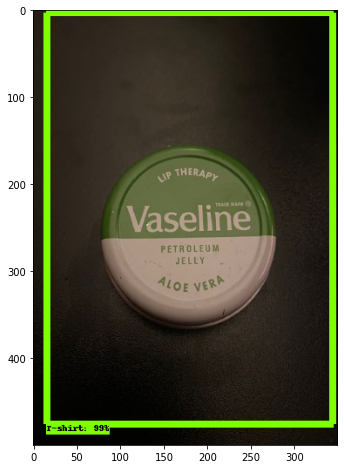

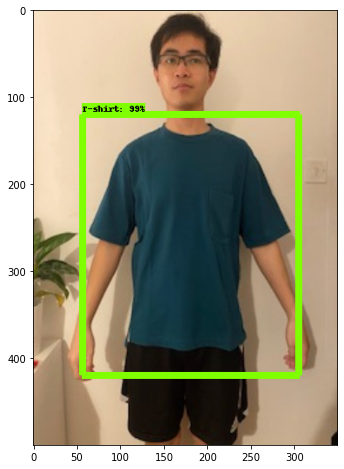

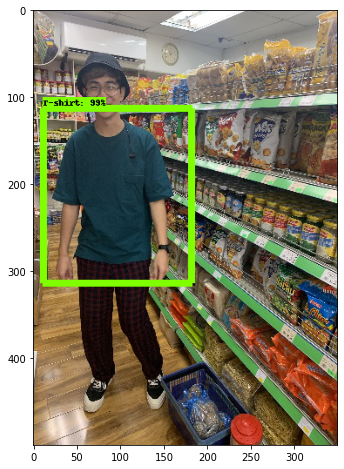

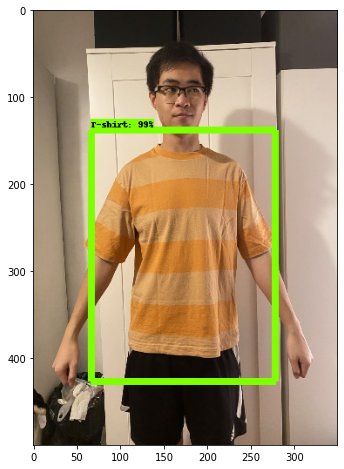

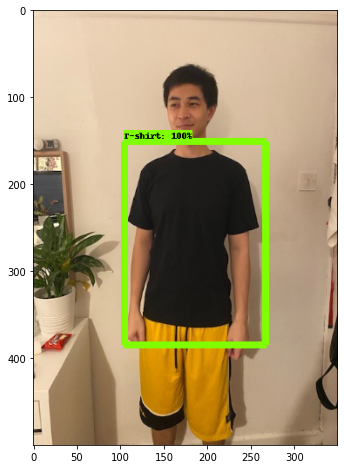

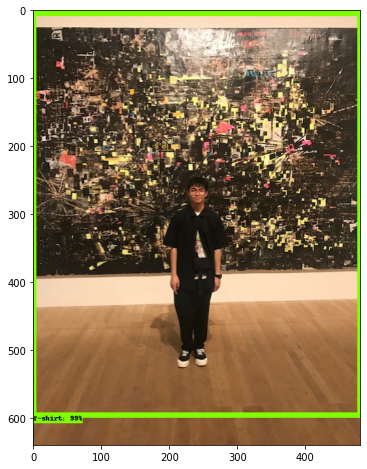

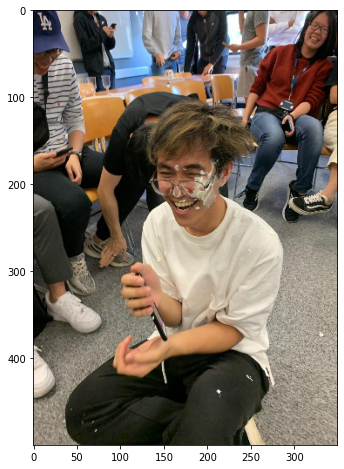

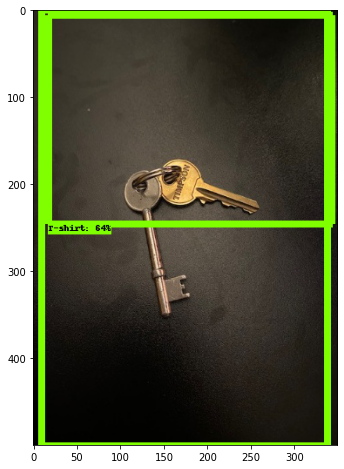

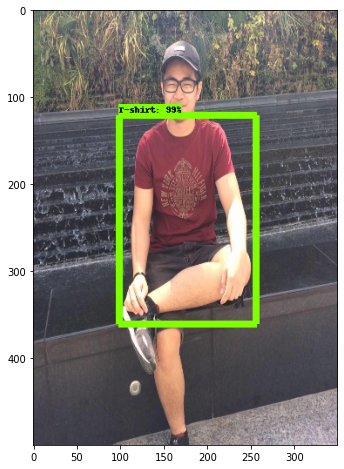

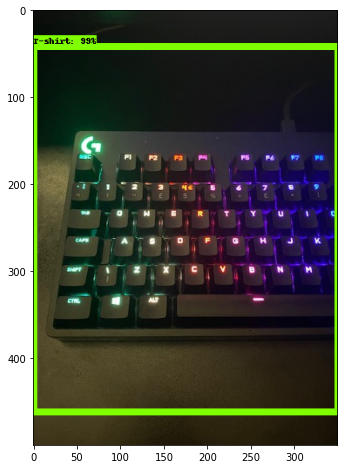

In [0]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

# This is needed to display the images.
%matplotlib inline

from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')


label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=num_classes, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)


def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {
                output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(
                    tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(
                    tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(
                    tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                           real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                           real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(
                output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict


#Visualising the detection boxes and plotting the test images
for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=8)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)